In [1]:
import importlib
import numpy as np
from scipy import stats
from tabulate import tabulate
import pandas as pd
import os
import itertools

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import matplotlib

from simulate_model import simulate
import simulate_Jordan_model as simulate_Jordan
from utils import joint_density

plt.rcParams.update({'font.size': 16})

<Figure size 72x72 with 0 Axes>

In [2]:
def simulate_model(config_name):
    config_module = importlib.import_module(f"configs.{config_name}")
    config = config_module.get_config()
    N_configs = len(config)

    alpha_range = np.arange(0,10,0.1)
    available_actions = {key: config[key]['available_actions'] for key in config.keys()}
    alpha_selfish_set = {key: alpha_range for key in config.keys()}
    alpha_social_set = {key: alpha_range for key in config.keys()}
    alpha_target = {key: config[key]['alpha_target'] for key in config.keys()}
    selfish_utilities = {key: config_module.get_selfish_utilities(key, available_actions[key]) for key in config.keys()}
    social_utilities = {key: config_module.get_social_utilities(key, available_actions[key]) for key in config.keys()}
    target_utilities = {key: config_module.get_target_utilities(key, available_actions[key]) for key in config.keys()}
    
    alpha_prior = joint_density.JointIndependent([stats.expon(scale=1/(1/3)),   # prior over alpha_selfish
                                                  stats.uniform(0, 10)])  # prior over alpha_social
    
    alpha_prior_discretized = {}
    for alpha_selfish in alpha_range:
        for alpha_social in alpha_range: 
            alpha_prior_discretized[(alpha_selfish, alpha_social)] = alpha_prior.pdf((alpha_selfish, alpha_social))
    normalizing_factor = np.sum(list(alpha_prior_discretized.values()))
    for alpha_selfish in alpha_range:
        for alpha_social in alpha_range: 
            alpha_prior_discretized[(alpha_selfish, alpha_social)] = alpha_prior_discretized[(alpha_selfish, alpha_social)] / normalizing_factor
            
    params = {'available_actions': available_actions,
              'alpha_selfish_set': alpha_selfish_set,
              'alpha_social_set': alpha_social_set,
              'alpha_target': alpha_target,
              'selfish_utilities': selfish_utilities,
              'social_utilities': social_utilities,
              'target_utilities': target_utilities,
              'alpha_prior': alpha_prior_discretized}

    for j, key in enumerate(config.keys()):
        utilities = [[i+1, action, selfish_utilities[key][action], social_utilities[key][action], target_utilities[key][action]] 
                     for i, action in enumerate(available_actions[key])]
        print(f"{key} utilities")
        print (tabulate(utilities, headers=["Action", "U_selfish", "U_social", "U_target"]))
        print("\n")

    full_model_data = simulate(config_name, config, params, save=True)

    return full_model_data

def preprocess_data(model_data, data_preprocessor_name):
    # preprocess data
    data_preprocessor = importlib.import_module(data_preprocessor_name)
    preprocessed_data = data_preprocessor.preprocess(model_data)
    return preprocessed_data

## Jordan & Rand, 2020 

In [3]:
# simulate the model
config_name = "paper.Jordan_Rand_2020.only_condition_audience1"
config_both_name = "paper.Jordan_Rand_2020.both_condition_audience1"
full_model_data = simulate_Jordan.simulate(config_name, config_both_name, save=True)

# preprocess, suitable for plotting
data_preprocessor_name = 'model_data.paper.Jordan_Rand_2020.preprocess'
model_data = preprocess_data(full_model_data, data_preprocessor_name)
model_data

Punishment-only utilities
    Action        U_selfish    U_social    U_target
--  ----------  -----------  ----------  ----------
 1  Not-punish            0           0           0
 2  Punish               -5          10         -50


Help-only utilities
    Action      U_selfish    U_social    U_target
--  --------  -----------  ----------  ----------
 1  Not-help            0           0           0
 2  Help              -20          10          15


Punishment-only: alpha_reputation_high = 350
Punishment-only: alpha_reputation_low = 250.00500000000002
Help-only: alpha_reputation_high = 350
Help-only: alpha_reputation_low = 250.00500000000002
Both - H: alpha_reputation_high = 350
Both - H: alpha_reputation_low = 250.00500000000002
Both - NH: alpha_reputation_high = 350
Both - NH: alpha_reputation_low = 250.00500000000002
Both - P: alpha_reputation_high = 350
Both - P: alpha_reputation_low = 250.00500000000002
Both - NP: alpha_reputation_high = 350
Both - NP: alpha_reputation_low = 2

,IV,condition,punish_prob
0,P-only,Low audience value,0.373278
1,P-only,High audience value,0.435286
2,H + P,Low audience value,0.304664
3,H + P,High audience value,0.330397


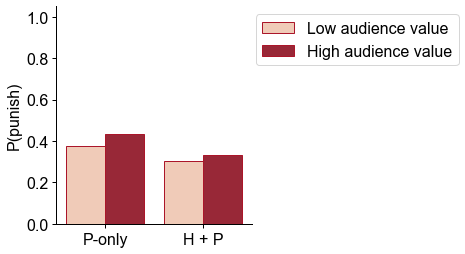

In [5]:
color_palette = sns.color_palette("RdBu", 10)
plt.figure(figsize=(3.5,4), facecolor='white')
palette = {"Low audience value": color_palette[3], "High audience value": color_palette[0]}

ax = sns.barplot(x='IV', y='punish_prob', hue='condition',
                 data=model_data, palette=palette)
plt.ylim([0,1.05])
ax.set_xticklabels(['P-only', 'H + P'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("")
plt.ylabel("P(punish)")
for patch in ax.patches:
    patch.set_edgecolor(color_palette[0])
plt.legend(title="", bbox_to_anchor=(1.8, 0.9, 0.3, 0.1), loc='best')

plt.savefig(f"results/model_figures/Jordan_Rand_2020_punish_prob.png", dpi=1000, bbox_inches='tight')
plt.show()

## Batistoni et al., 2021

### Stage 1: Decide whether to punish

In [3]:
# simulate the model
config_name = "paper.Batistoni_2021.exp1_stage1_audience1"
full_model_data = simulate_model(config_name)

# preprocess, suitable for plotting
data_preprocessor_name = 'model_data.paper.Batistoni_2021.preprocess_stage1'
model_data = preprocess_data(full_model_data, data_preprocessor_name)
model_data

Punisher utilities
    Action        U_selfish    U_social    U_target
--  ----------  -----------  ----------  ----------
 1  Not-punish            0         0             0
 2  Punish              -25         5.5         -55


Punisher: alpha_reputation_high = 350
Punisher: alpha_reputation_low = 250.00500000000002
paper/Batistoni_2021/exp1_stage1_audience1


,IV,condition,punish_prob
0,Punisher,Low audience value,0.394206
1,Punisher,High audience value,0.577528


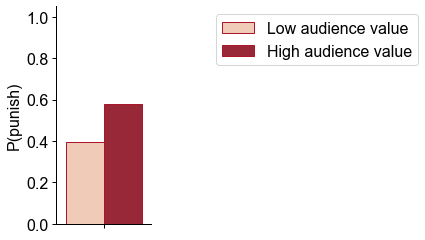

In [4]:
color_palette = sns.color_palette("RdBu", 10)
palette = {"Low audience value": color_palette[3], "High audience value": color_palette[0]}

plt.figure(figsize=(1.7,4), facecolor='white')
ax = sns.barplot(x='IV', y='punish_prob', hue='condition', 
                 data=model_data, palette=palette)
plt.ylim([0,1.05])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("")
ax.set(xticklabels=[])
plt.ylabel("P(punish)")
for patch in ax.patches:
    patch.set_edgecolor(color_palette[0])
plt.legend(title="", bbox_to_anchor=(3.60, 0.9, 0.3, 0.1), loc='best')

plt.savefig(f"results/model_figures/Batistoni_2021_punish_prob.png", dpi=1000, bbox_inches='tight')
plt.show()

### Stage 2: Decide punishment severity

In [5]:
# simulate the model
config_name = "paper.Batistoni_2021.exp1_stage2_audience1"
full_model_data = simulate_model(config_name)

# preprocess, suitable for plotting
data_preprocessor_name = 'model_data.paper.Batistoni_2021.preprocess_stage2'
model_data = preprocess_data(full_model_data, data_preprocessor_name)
model_data

Punisher utilities
      Action    U_selfish    U_social    U_target
--  --------  -----------  ----------  ----------
 1        10         -4.5    0.179862         -10
 2        20         -9      0.474259         -20
 3        30        -13.5    1.19203          -30
 4        40        -18      2.68941          -40
 5        50        -22.5    5                -50
 6        60        -27      7.31059          -60
 7        70        -31.5    8.80797          -70
 8        80        -36      9.52574          -80
 9        90        -40.5    9.82014          -90
10       100        -45      9.93307         -100


Punisher: alpha_reputation_high = 350
Punisher: alpha_reputation_low = 250.00500000000002
paper/Batistoni_2021/exp1_stage2_audience1


,IV,condition,punish_severity
0,Punisher,Low audience value,46.748340
1,Punisher,High audience value,53.933706


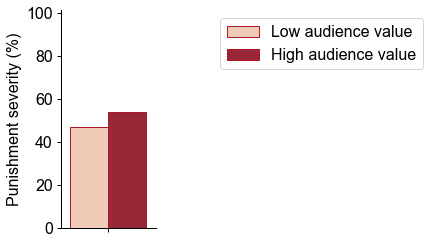

In [6]:
plt.figure(figsize=(1.7,4), facecolor='white')
ax = sns.barplot(x='IV', y='punish_severity', hue='condition', 
                 data=model_data, palette=palette)
plt.ylim([0,101])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("")
ax.set(xticklabels=[])
plt.ylabel("Punishment severity (%)")
for patch in ax.patches:
    patch.set_edgecolor(color_palette[0])
plt.legend(title="", bbox_to_anchor=(3.60, 0.9, 0.3, 0.1), loc='best')
    
plt.savefig(f"results/model_figures/Batistoni_2021_punish_severity_mean.png", dpi=1000, bbox_inches='tight')
plt.show()

In [7]:
# preprocess, suitable for plotting
data_preprocessor_name = 'model_data.paper.Batistoni_2021.preprocess_stage2_dist'
model_data = preprocess_data(full_model_data, data_preprocessor_name)

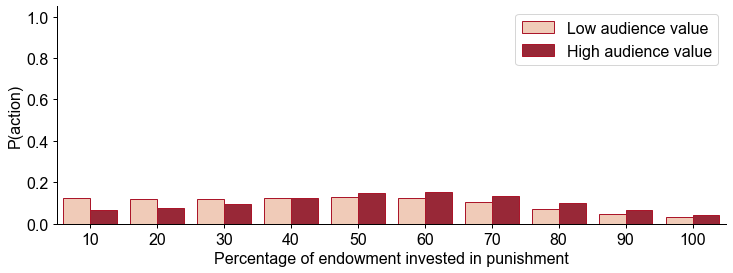

In [8]:
plt.figure(figsize=(12,4), facecolor='white')
ax = sns.barplot(x='IV', y='punish_prob', hue='condition', 
                 data=model_data, palette=palette)
plt.ylim([0,1.05])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("Percentage of endowment invested in punishment")
plt.ylabel("P(action)")
for patch in ax.patches:
    patch.set_edgecolor(color_palette[0])
plt.legend(title="", bbox_to_anchor=(0.70, 0.9, 0.3, 0.1), loc='best')

plt.savefig(f"results/model_figures/Batistoni_2021_punish_severity_dist.png", dpi=1000, bbox_inches='tight')
plt.show()

## Rai, 2021

In [9]:
# simulate the model
config_name = "paper.Rai_2021.exp1_audience1"
full_model_data = simulate_model(config_name)

# preprocess, suitable for plotting
data_preprocessor_name = 'model_data.paper.Rai_2021.preprocess_exp1'
model_data = preprocess_data(full_model_data, data_preprocessor_name)
model_data

No-gain utilities
    Action        U_selfish    U_social    U_target
--  ----------  -----------  ----------  ----------
 1  Not-punish            0           0           0
 2  Punish                0          10          -5


Small-gain utilities
    Action        U_selfish    U_social    U_target
--  ----------  -----------  ----------  ----------
 1  Not-punish            0           0           0
 2  Punish               15          10          -5


No-gain: alpha_reputation_high = 350
No-gain: alpha_reputation_low = 250.00500000000002
Small-gain: alpha_reputation_high = 350
Small-gain: alpha_reputation_low = 250.00500000000002
paper/Rai_2021/exp1_audience1


,IV,condition,punish_prob
0,No-gain,Base punisher,0.675377
1,Small-gain,Base punisher,0.794362
2,No-gain,Low audience value,0.675377
3,Small-gain,Low audience value,0.431482


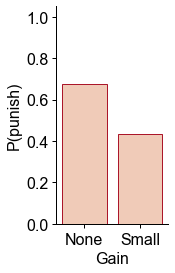

In [10]:
color_palette = sns.color_palette("RdBu", 10)
palette ={"Base punisher": color_palette[4], "Low audience value": color_palette[0]}

tmp_data = model_data[model_data['condition']=="Low audience value"]
plt.figure(figsize=(2,4), facecolor='white')
ax = sns.barplot(x='IV', y='punish_prob',
                 data=tmp_data, color=color_palette[3])
plt.ylim([0,1.05])
ax.set_xticklabels(['None', 'Small'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("Gain")
plt.ylabel("P(punish)")
for patch in ax.patches:
    patch.set_edgecolor(color_palette[0])
# plt.legend(title="", bbox_to_anchor=(1.0, 0.9, 0.3, 0.1), loc='best')
    
plt.savefig(f"results/model_figures/Rai_2021_study1.png", dpi=1000, bbox_inches='tight')
plt.show()

In [11]:
# simulate the model
config_name = "paper.Rai_2021.exp3a_audience1"
full_model_data = simulate_model(config_name)

# preprocess, suitable for plotting
data_preprocessor_name = 'model_data.paper.Rai_2021.preprocess_exp3a'
model_data = preprocess_data(full_model_data, data_preprocessor_name)
model_data

No-gain utilities
    Action        U_selfish    U_social    U_target
--  ----------  -----------  ----------  ----------
 1  Not-punish            0           0           0
 2  Punish                0         100        -100


Small-gain utilities
    Action        U_selfish    U_social    U_target
--  ----------  -----------  ----------  ----------
 1  Not-punish            0           0           0
 2  Punish                5         100        -100


Large-gain utilities
    Action        U_selfish    U_social    U_target
--  ----------  -----------  ----------  ----------
 1  Not-punish            0           0           0
 2  Punish              500         100        -100


No-gain: alpha_reputation_high = 1200
No-gain: alpha_reputation_low = 857.1600000000001
Small-gain: alpha_reputation_high = 1200
Small-gain: alpha_reputation_low = 857.1600000000001
Large-gain: alpha_reputation_high = 1200
Large-gain: alpha_reputation_low = 857.1600000000001
paper/Rai_2021/exp3a_audience1


,IV,condition,punish_prob
0,No-gain,Base punisher,5.765077
1,Small-gain,Base punisher,5.840879
2,Large-gain,Base punisher,6.881644
3,No-gain,High audience value,5.765077
4,Small-gain,High audience value,5.027597
5,Large-gain,High audience value,5.793115


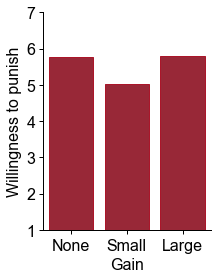

In [12]:
color_palette = sns.color_palette("RdBu", 10)
palette ={"Base punisher": color_palette[4], "High audience value": color_palette[0]}

tmp_data = model_data[model_data['condition']=="High audience value"]
plt.figure(figsize=(3,4), facecolor='white')
ax = sns.barplot(x='IV', y='punish_prob',
                 data=tmp_data, color=color_palette[0])
plt.ylim([1,7])
ax.set_xticklabels(['None', 'Small', 'Large'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("Gain")
plt.ylabel("Willingness to punish")
for patch in ax.patches:
    patch.set_edgecolor(color_palette[0])
# plt.legend(title="", bbox_to_anchor=(1.0, 0.9, 0.3, 0.1), loc='best')
    
plt.savefig(f"results/model_figures/Rai_2021_study3a.png", dpi=1000, bbox_inches='tight')
plt.show()